
# TP4: Encodeador de música



## Indice
1.
2.
3.
4.



## Importe de librerias e inicializacion

In [ ]:
%pip install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cpu


In [ ]:
%pip install pydub scikit-learn wandb torchview torchviz graphviz matplotlib tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.2/249.2 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.4 MB/s eta 0:00:00
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4133 sha256=a6fcd91fa8556fc978ce0f1821d9129c521ffb22b70347dab08886655c9a574b
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [ ]:
%pip install wandb

In [ ]:
!pip install torchaudio
!pip install  pydub
import os
import torch
import torchaudio
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchaudio.datasets import GTZAN
from torch.utils.data import DataLoader
import torchaudio.transforms as tt
from torch.utils.data import random_split
import matplotlib
import matplotlib.pyplot as plt
import IPython
from tqdm import tqdm
import gc
from sklearn.metrics import accuracy_score, confusion_matrix
from pydub import AudioSegment
import torch.optim as optim
import wandb
wandb.login()
%matplotlib inline


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


bfbad9b2649155692b5f97a49a43c0eeb66dff4a

In [ ]:
device = torch.device(
    'mps:0' if torch.backends.mps.is_available() else 'cuda:0' if torch.cuda.is_available() else 'cpu'
    )

device

device(type='cuda', index=0)

## Importe de datos y visualizacion

In [ ]:
project_name='Music_genre_classification'

### Conectamos la notebook a gdrive y seteamos data_dir con el path a los archivos.





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


data_dir es el path donde pusimos la carpeta genres. "'//content/drive/MyDrive/Materias/TD6 - Inteligencia Artificial/TPs/2023/TP4/genres/'" es un ejemplo. Modificar.

In [ ]:
import os
data_dir='/content/drive/MyDrive/genres_5sec/'
list_files=os.listdir(data_dir)
classes=[]
for file in list_files:
  name='{}/{}'.format(data_dir,file)
  if os.path.isdir(name):
    classes.append(file)
classes

['rock',
 'pop',
 'hiphop',
 'disco',
 'blues',
 'reggae',
 'country',
 'metal',
 'classical',
 'jazz']

In [ ]:
samplerate=22050
def parse_genres(fname):
    parts = fname.split('/')[-1].split('.')[0]
    return parts #' '.join(parts[0])

class MusicDataset(Dataset):
    def __init__(self, root):
        super().__init__()
        self.root = root
        self.files =[]
        for c in classes:
          self.files = self.files + [fname for fname in os.listdir(os.path.join(root,c)) if fname.endswith('.wav')]
        self.classes = list(set(parse_genres(fname) for fname in self.files))
        #self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
            fname = self.files[i]

            #img = self.transform(open_image(fpath))
            genre = parse_genres(fname)
            fpath = os.path.join(self.root,genre, fname)
            genre_index = self.classes.index(genre)
            audio = torchaudio.load(fpath)[0]

            spectogram = tt.Spectrogram()(audio)

            return audio,spectogram, genre_index

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        fmt_str += '    Root Location: {}\n'.format(self.root)
        # List classes
        fmt_str += '    Classes: {}\n'.format(self.classes)
        return fmt_str
dataset = MusicDataset(data_dir)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Separamos en train y val

In [ ]:
def create_data_loaders(dataset, batch_size=20, val_size=100, test_size=100, num_workers=4):
    random_seed = 42
    torch.manual_seed(random_seed)

    train_size = len(dataset) - val_size - test_size

    train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

    train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    valid_dl = DataLoader(val_ds, batch_size*2, num_workers=num_workers, pin_memory=True)
    test_dl = DataLoader(test_ds, 1, num_workers=num_workers, pin_memory=True)

    return train_dl, valid_dl, test_dl

In [ ]:
batch_size = 20
val_size=100
test_size=100
train_size = len(dataset) - val_size - test_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_dl, valid_dl, test_dl = create_data_loaders(dataset, batch_size=batch_size, val_size=val_size, test_size=test_size, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Visualización de los archivos

In [ ]:

waveform,spectogram,label= dataset[0]
print("shape of waveform {}, sample rate with {}, label is {} ".format(waveform.size(),samplerate,label))
# label = 9 es rock

shape of waveform torch.Size([1, 110250]), sample rate with 22050, label is 1 


shape of spectogram torch.Size([1, 201, 552])


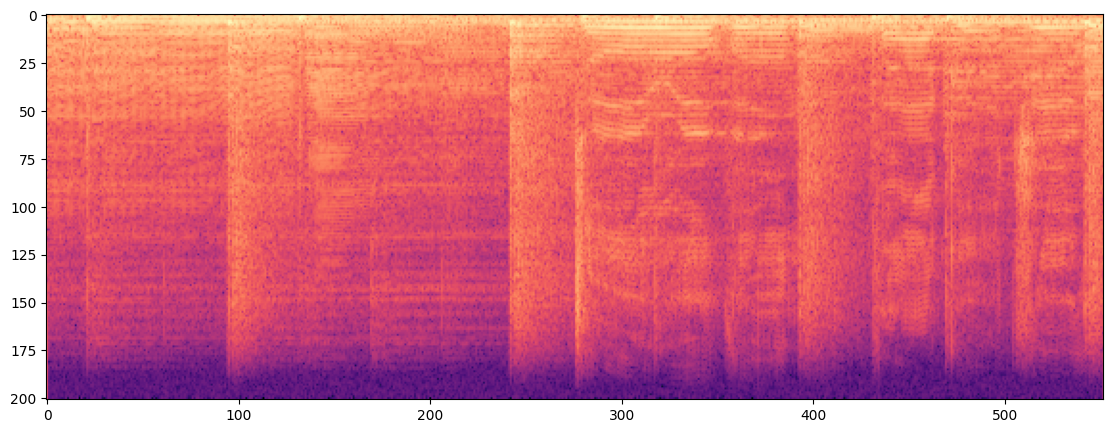

In [ ]:
print("shape of spectogram {}".format(spectogram.size()))

plt.figure(figsize=(20, 5))
plt.imshow(spectogram.log2()[0,:,:].numpy(),cmap='magma')

Waveform: tensor([[0.1008, 0.1524, 0.1216,  ..., 0.2740, 0.2587, 0.2402]])



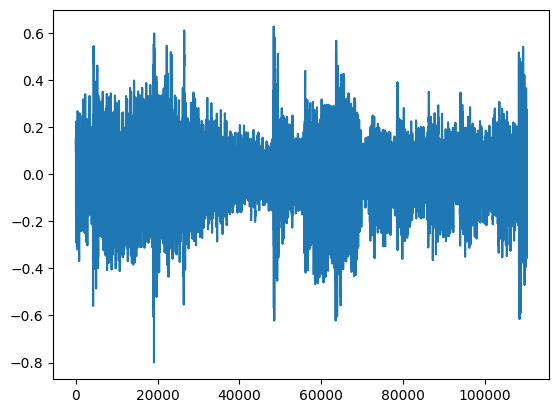

In [ ]:
print("Waveform: {}\n".format(waveform))

plt.figure()
plt.plot(waveform.t().numpy())

Escuchamos el espectograma con la librería de audio

In [ ]:
import IPython
IPython.display.Audio(waveform,rate=samplerate)

In [ ]:
spectogram.size()

torch.Size([1, 201, 552])

In [ ]:
random_seed = 42
torch.manual_seed(random_seed);
val_size = 100
test_size = 100
train_size = len(dataset) - val_size - test_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds),len(val_ds),len(test_ds)

(790, 100, 100)

In [ ]:
from torch.utils.data import DataLoader
batch_size = 20

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_ds,1, num_workers=4, pin_memory=True)

creamos un aforma la cual permite ver y escuhcar la version original y la reconstruida.

In [ ]:
def visualize_dual(model, dataset, index, device):
    model.eval()
    waveform, spectogram, label = dataset[index]

    audio = waveform.to(device)
    spec = spectogram.to(device)

    # Reconstrucción
    rec_audio = model(audio).to('cpu').flatten().detach()
    print(f'shape audio: {audio.shape}')
    print(f'shape rec_audio: {rec_audio.shape}')

    rec_spec = tt.Spectrogram()(rec_audio)
    print(f'shape spec: {spec.shape}')
    print(f'shape rec_spec: {rec_spec.shape}')

    # Visualización
    fig, axs = plt.subplots(2, 2, figsize=(20, 8))

    axs[0, 0].plot(audio.squeeze().detach().cpu().numpy())
    axs[0, 0].set_title("Original Waveform")

    axs[0, 1].plot(rec_audio.t().numpy())
    axs[0, 1].set_title("Waveform Reconstruido")

    axs[1, 0].imshow(spec.log2().squeeze().detach().cpu().numpy(), cmap='magma')
    axs[1, 0].set_title("Spectogram Original")

    axs[1, 1].imshow(rec_spec.log2().squeeze().detach().cpu().numpy(), cmap='magma')
    axs[1, 1].set_title("Spectogram Reconstruido")

    print("Audio Original")
    display(IPython.display.Audio(waveform.squeeze(), rate=samplerate))
    print("Audio Reconstruido")
    display(IPython.display.Audio(rec_audio, rate=samplerate))

## Ejercicio 1

### Arquitectura: Autoencoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, n_input, c_1, c_2, c_3, c_4, k_1, k_2, k_3, k_4, s_1, s_2, s_3, s_4, p_1, p_2, p_3, p_4):
        super(Encoder, self).__init__()

        self.conv1 = nn.Conv1d(n_input, c_1, kernel_size=k_1, padding=p_1, stride=s_1)
        self.conv2 = nn.Conv1d(c_1, c_2, kernel_size=k_2, padding=p_2, stride=s_2)
        self.conv3 = nn.Conv1d(c_2, c_3, kernel_size=k_3, padding=p_3, stride=s_3)
        # self.conv4 = nn.Conv1d(ec_3, ec_4, kernel_size=ek_4, padding=ep_4, stride=es_4)

    def forward(self, x):
        # print("Encoder input shape:", x.shape)

        x = F.leaky_relu(self.conv1(x))
        # print("Encoder Conv1 shape:", x.shape)

        x = F.leaky_relu(self.conv2(x))
        # print("Encoder Conv2 shape:", x.shape)

        x = F.leaky_relu(self.conv3(x))
        # print("Encoder Conv3 shape:", x.shape)

        # x = F.softsign(self.conv4(x))
        # print("Bottle_neck shape:", x.shape)
        return x

class Decoder(nn.Module):
    def __init__(self, n_input, c_1, c_2, c_3, c_4, k_1, k_2, k_3, k_4, s_1, s_2, s_3, s_4, p_1, p_2, p_3, p_4):
        super(Decoder, self).__init__()

        # self.deconv4 = nn.ConvTranspose1d(dc_4, dc_3, kernel_size=dk_4, stride=ds_4, padding=dp_4)
        self.deconv3 = nn.ConvTranspose1d(c_3, c_2, kernel_size=k_3, stride=s_3, padding=p_3)
        self.deconv2 = nn.ConvTranspose1d(c_2, c_1, kernel_size=k_2, stride=s_2, padding=p_2)
        self.deconv1 = nn.ConvTranspose1d(c_1, n_input, kernel_size=k_1, stride=s_1, padding=p_1)

    def forward(self, x):
        # x = F.softsign(self.deconv4(x))
        # print("Decoder Conv4 shape:", x.shape)

        x = F.leaky_relu(self.deconv3(x))
        # print("Decoder Conv3 shape:", x.shape)

        x = F.leaky_relu(self.deconv2(x))
        # print("Decoder Conv2 shape:", x.shape)

        x = self.deconv1(x)
        # print("Decoder Conv1 shape:", x.shape)
        return x

class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.bottle_neck = None

    def forward(self, x):
        x = self.encoder(x)
        self.bottle_neck = x.shape
        x = self.decoder(x)
        return x

n_input = 1
# Channels
c_1 = 64
c_2 = 32
c_3 = 8
c_4 = 4

# Kernel size
k_1 = 8
k_2 = 6
k_3 = 5
k_4 = 2

# Stride
s_1 = 6
s_2 = 3
s_3 = 2
s_4 = 3

# Padding
p_1 = 4
p_2 = 4
p_3 = 4
p_4 = 4

audio_size = (batch_size, 1, 110250)  # Ejemplo de forma
encoder = Encoder(n_input, c_1, c_2, c_3, c_4, k_1, k_2, k_3, k_4, s_1, s_2, s_3, s_4, p_1, p_2, p_3, p_4)
decoder = Decoder(n_input, c_1, c_2, c_3, c_4, k_1, k_2, k_3, k_4, s_1, s_2, s_3, s_4, p_1, p_2, p_3, p_4)
model = Autoencoder(encoder, decoder).to(device)

dummy_input = torch.rand(audio_size).to(device)
output = model(dummy_input)
print('Bottle Neck:', model.bottle_neck, (model.bottle_neck[1]*model.bottle_neck[2]))
print("Output shape:", output.size())
print(model)

# output comun = (input_size + 2p - kernel)/stride + 1.
# output traspuesta = (input_size - 1) * stride - 2Padding + kernel.


Bottle Neck: torch.Size([20, 8, 3066]) 24528
Output shape: torch.Size([20, 1, 110250])
Autoencoder(
  (encoder): Encoder(
    (conv1): Conv1d(1, 64, kernel_size=(8,), stride=(6,), padding=(4,))
    (conv2): Conv1d(64, 32, kernel_size=(6,), stride=(3,), padding=(4,))
    (conv3): Conv1d(32, 8, kernel_size=(5,), stride=(2,), padding=(4,))
  )
  (decoder): Decoder(
    (deconv3): ConvTranspose1d(8, 32, kernel_size=(5,), stride=(2,), padding=(4,))
    (deconv2): ConvTranspose1d(32, 64, kernel_size=(6,), stride=(3,), padding=(4,))
    (deconv1): ConvTranspose1d(64, 1, kernel_size=(8,), stride=(6,), padding=(4,))
  )
)


### Entrenamos autoencoder

In [ ]:
Train_1 = False

In [ ]:
import gc
def train_autoencoder(model, train_dl, valid_dl, ckpt, lr=0.001, num_epochs=25, log=False):
      device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      model.to(device)

      loss_function = nn.MSELoss()
      optimizer = optim.Adam(model.parameters(), lr=lr)
      torch.cuda.empty_cache()
      gc.collect()
      valid_losses = []

      if log:
          Bott_neck = model.bottle_neck[1:]
          Bott_neck = str(model.bottle_neck[1:][0]) + ',' + str(model.bottle_neck[1:][1])
          wandb.finish()
          wandb.init(
              project=project_name,
              name=f"{model.__class__.__name__}_EL:[{Bott_neck}]",
              config={
                  "learning_rate": lr,
                  # Include other parameters as needed
                  "batch_size": batch_size,
                  "epochs": num_epochs,
                  "c_1": c_1,
                  "c_2": c_2,
                  "c_3": c_3,
                  "c_4": c_4,
                  "k_1": k_1,
                  "k_2": k_2,
                  "k_3": k_3,
                  "k_4": k_4,
                  "s_1": s_1,
                  "s_2": s_2,
                  "s_3": s_3,
                  "s_4": s_4,
                  "p_1": p_1,
                  "p_2": p_2,
                  "p_3": p_3,
                  "p_4": p_4,
              },
          )

      for epoch in range(num_epochs):
          train_loss = []
          val_loss = []

          # TRAIN
          model.train()
          for wav, spectogram, genre_index in train_dl:
              optimizer.zero_grad()
              wav = wav.to(device)

              # Forward
              out = model(wav)
              loss = loss_function(out, wav)

              # Backward
              loss.backward()
              optimizer.step()
              train_loss.append(loss.item())

              # Liberamos memoria RAM
              del spectogram
              del wav
              del loss
              del out
              torch.cuda.empty_cache()
              gc.collect()

          # VALIDATION
          model.eval()
          with torch.no_grad():
              for wav, spectogram, genre_index in valid_dl:
                  wav = wav.to(device)

                  out = model(wav)
                  loss = loss_function(out, wav)
                  val_loss.append(loss.item())

                  # Liberamos memoria RAM
                  del spectogram
                  del wav
                  del genre_index
                  del loss
                  del out
                  torch.cuda.empty_cache()
                  gc.collect()

          valid_loss = np.mean(val_loss)
          if log:
              wandb.log({
                  "train_loss": np.mean(train_loss),
                  "val_loss": valid_loss
              })
          print('Epoch: [%d/%d], Train loss: %.4f, Valid loss: %.4f' % (epoch + 1, num_epochs, np.mean(train_loss),
                                                                        valid_loss))

          # Save model
          valid_losses.append(valid_loss.item())
          if np.argmin(valid_losses) == epoch:
              print('Saving the best model at %d epochs!' % epoch)
              torch.save(model.state_dict(), ckpt)

      if log:
          wandb.finish()
if Train_1:
  train_autoencoder(model, train_dl, valid_dl, 'best_model_1.ckpt', lr=0.001, num_epochs=25, log=True)

In [ ]:
# Load the best model
S = torch.load('best_model_1.ckpt')
model.load_state_dict(S)
print('loaded!')

loaded!


### Display

In [ ]:
original = test_dl.dataset[18]
print(original)
audio = original[0]
idnex = original[2]
print("shape of waveform {}, sample rate with {}, label is {} ".format(audio.size(),samplerate,idnex))

(tensor([[-0.0924, -0.0648, -0.0625,  ...,  0.1305,  0.1205,  0.1432]]), tensor([[[2.6156e-02, 2.7060e-01, 8.3053e+00,  ..., 1.8853e-01,
          7.2150e+00, 1.0930e+02],
         [2.4730e+01, 3.2395e+01, 3.9160e+01,  ..., 1.3516e+00,
          3.7158e+01, 5.0093e+01],
         [7.1364e+01, 1.5417e+01, 4.9893e+01,  ..., 1.4669e+00,
          5.1359e+01, 1.0859e+02],
         ...,
         [6.1858e-02, 1.3344e-02, 2.1580e-02,  ..., 1.9755e-04,
          1.6874e-03, 2.3704e-02],
         [4.4652e-03, 5.2992e-02, 7.7936e-03,  ..., 6.9916e-04,
          6.6534e-04, 6.5014e-03],
         [1.2225e-02, 1.0037e-02, 1.0836e-02,  ..., 5.8115e-06,
          1.1450e-03, 9.1374e-04]]]), 9)
shape of waveform torch.Size([1, 110250]), sample rate with 22050, label is 9 


shape audio: torch.Size([1, 110250])
shape rec_audio: torch.Size([110250])
shape spec: torch.Size([1, 201, 552])
shape rec_spec: torch.Size([201, 552])
Audio Original


Audio Reconstruido


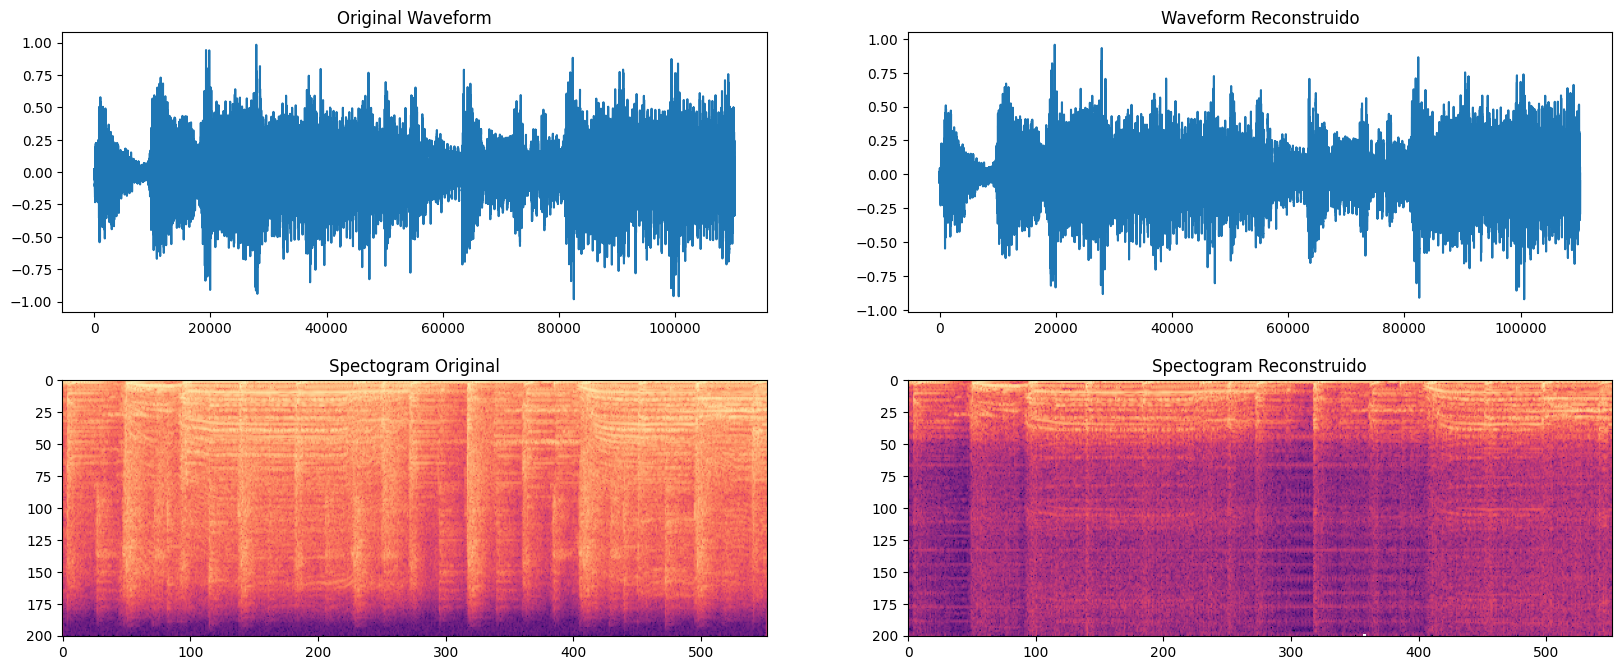

In [ ]:
visualize_dual(model, test_dl.dataset, 50, device)

## Ejerecio 2

Importo los 3 modelos distinos:
* Chico  (X1/2)
* Normal (X1)
* Grande (X2)


### creacion de los encoders y entrenamiento



In [ ]:
esp_lat_chico=4
esp_lat_normal=8
esp_lat_grande=16

encoder_chico = Encoder(n_input, c_1, c_2, esp_lat_chico, c_4, k_1, k_2, k_3, k_4, s_1, s_2, s_3, s_4, p_1, p_2, p_3, p_4)
decoder_chico = Decoder(n_input, c_1, c_2, esp_lat_chico, c_4, k_1, k_2, k_3, k_4, s_1, s_2, s_3, s_4, p_1, p_2, p_3, p_4)

encoder_normal = Encoder(n_input, c_1, c_2, esp_lat_normal, c_4, k_1, k_2, k_3, k_4, s_1, s_2, s_3, s_4, p_1, p_2, p_3, p_4)
decoder_normal = Decoder(n_input, c_1, c_2, esp_lat_normal, c_4, k_1, k_2, k_3, k_4, s_1, s_2, s_3, s_4, p_1, p_2, p_3, p_4)

encoder_grande = Encoder(n_input, c_1, c_2, esp_lat_grande, c_4, k_1, k_2, k_3, k_4, s_1, s_2, s_3, s_4, p_1, p_2, p_3, p_4)
decoder_grande = Decoder(n_input, c_1, c_2, esp_lat_grande, c_4, k_1, k_2, k_3, k_4, s_1, s_2, s_3, s_4, p_1, p_2, p_3, p_4)

In [ ]:
encoder_chico

Encoder(
  (conv1): Conv1d(1, 64, kernel_size=(8,), stride=(6,), padding=(4,))
  (conv2): Conv1d(64, 32, kernel_size=(6,), stride=(3,), padding=(4,))
  (conv3): Conv1d(32, 4, kernel_size=(5,), stride=(2,), padding=(4,))
)

In [ ]:
encoder_normal

Encoder(
  (conv1): Conv1d(1, 64, kernel_size=(8,), stride=(6,), padding=(4,))
  (conv2): Conv1d(64, 32, kernel_size=(6,), stride=(3,), padding=(4,))
  (conv3): Conv1d(32, 8, kernel_size=(5,), stride=(2,), padding=(4,))
)

In [ ]:
encoder_grande

Encoder(
  (conv1): Conv1d(1, 64, kernel_size=(8,), stride=(6,), padding=(4,))
  (conv2): Conv1d(64, 32, kernel_size=(6,), stride=(3,), padding=(4,))
  (conv3): Conv1d(32, 16, kernel_size=(5,), stride=(2,), padding=(4,))
)

entreno como si fuesen auto encoders y veo cual es su espacio latente

In [ ]:
model_chico = Autoencoder(encoder_chico, decoder_chico).to(device)
model_normal = Autoencoder(encoder_normal, decoder_normal).to(device)
model_grande = Autoencoder(encoder_grande, decoder_grande).to(device)


for model in [model_chico,model_normal,model_grande]:
  audio_size = (batch_size, 1, 110250)  # Ejemplo de forma
  dummy_input = torch.rand(audio_size).to(device)
  output = model(dummy_input)
  espacio_latente_n = (model.bottle_neck[1]*model.bottle_neck[2])
  model_name = [name for name, obj in globals().items() if obj is model][0]
  print(f'Espacio latente {model_name}:', model.bottle_neck,' = ', espacio_latente_n)

Espacio latente model: torch.Size([20, 4, 3066])  =  12264
Espacio latente model: torch.Size([20, 8, 3066])  =  24528
Espacio latente model: torch.Size([20, 16, 3066])  =  49056


In [ ]:
espacio_latente_chico=12264
espacio_latente_normal=24528
espacio_latente_grande =49056

In [ ]:
entrenaminto_autoencoder_2 = False

In [ ]:
if entrenaminto_autoencoder_2:
  for model in [model_chico,model_normal,model_grande]:
      model_name = [name for name, obj in globals().items() if obj is model][0]
      train_autoencoder(model, train_dl, valid_dl,f'{model_name}_2.ckpt', lr=0.001, num_epochs=25, log=True)

### Guardamos los DataLoaders para cada modelo con los espacios latentes de lso audios encodeados

In [ ]:
def create_dl(model,train_ds,val_ds,test_ds,model_name):
    S = torch.load(f'{model_name}_2.ckpt')
    model.load_state_dict(S)
    print(f'loaded {model_name}_2.ckpt!')

    def encodeo(ds):
      i = 0
      outputs = []
      while i < len(ds):
          waveform,spec, label = ds[i]
          # Modificar aquí para agregar dimensión en el canal
          input_tensor = torch.FloatTensor(waveform).unsqueeze(1)
          input_tensor = input_tensor.to(device)

          # Aplicamos el autoencoder
          with torch.no_grad():
              encoded_tensor = model.encoder(input_tensor)
              flattened_tensor = encoded_tensor.flatten()
              flattened_tensor = flattened_tensor.unsqueeze(1).permute(1, 0)
              outputs.append((flattened_tensor.cpu(), label))
          i = i+1
      return outputs

    print('start')
    outputs_train = encodeo(train_ds)
    print('listo train')
    outputs_val = encodeo(val_ds)
    print('listo val')
    outputs_test = encodeo(test_ds)
    print('finish')
    train_dl = DataLoader(outputs_train, batch_size, shuffle=True, num_workers=4, pin_memory=True)
    valid_dl = DataLoader(outputs_val, batch_size * 2, num_workers=4, pin_memory=True)
    test_dl = DataLoader(outputs_test,1, num_workers=4, pin_memory=True)
    return train_dl,valid_dl,test_dl

In [ ]:

train_dl_chico, valid_dl_chico, test_dl_chico = create_dl(model_chico,train_ds,val_ds,test_ds,'model_chico')
print()
train_dl_normal, valid_dl_normal, test_dl_normal = create_dl(model_normal,train_ds,val_ds,test_ds,'model_normal')
print()
train_dl_grande, valid_dl_grande, test_dl_grande = create_dl(model_grande,train_ds,val_ds,test_ds,'model_grande')

loaded model_chico_2.ckpt!
start
listo train
listo val
finish

loaded model_normal_2.ckpt!
start
listo train
listo val
finish

loaded model_grande_2.ckpt!
start
listo train
listo val
finish


### Clasificacion

Clasificamos los also espacios a ver si sigue capatando bien los generos y ver que tan representativos son

In [ ]:
train_clasificador  = True

In [ ]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=34, stride=8, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=8, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(2)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(2)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        # print(x.shape)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

cnn = M5(n_input=1, n_output=len(classes))
cnn.to(device)
print(cnn)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(cnn)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(8,), stride=(8,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=10, bias=True)
)
Number 

In [ ]:
def train_calssification(cnn, train_dl,valid_dl,espacio_latente_n,exp_name, lr=0.001, num_epochs=25, log=False):
    #divido en trian_dl y val_dl al data nueva de las cancione sencodeadas
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(cnn.parameters(), lr=lr)
    valid_losses = []
    torch.cuda.empty_cache()
    gc.collect()
    if log:
        wandb.finish()
        wandb.init(
            project=project_name,
            name=f"{str(exp_name)}_EL:[{espacio_latente_n}]",
            config={
                "Espacio latente":espacio_latente_n,
            },
        )

    for epoch in range(num_epochs):
      losses = []

      # Train
      cnn.train()
      for wav, genre_index in train_dl:
          optimizer.zero_grad()  # Clear gradients
          wav=wav.to(device)
          genre_index =torch.as_tensor(genre_index).to(device)

          # Forward
          out = cnn(wav)
          #M5
          loss = F.nll_loss(out.squeeze(), genre_index)

          # Backward
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          losses.append(loss.item())
          del wav
          del genre_index
          del loss
          del out
          torch.cuda.empty_cache()
          gc.collect()

      print('Epoch: [%d/%d], Train loss: %.4f' % (epoch+1, num_epochs, np.mean(losses)))

      # Validation
      cnn.eval()
      y_true = []
      y_pred = []
      losses = []
      correct =0
      for wav, genre_index in valid_dl:
          #print(wav, genre, index)
          wav = wav.to(device)
          genre_index = genre_index.to(device)

          out = cnn(wav)
          #M5
          loss = F.nll_loss(out.squeeze(), genre_index)

          losses.append(loss.item())
          #M5
          pred= out.argmax(dim=-1).flatten()
          # append labels and predictions
          correct += pred.eq(genre_index).sum().item()
          y_true.extend(genre_index)
          y_pred.extend(pred)
          del wav
          del genre_index
          del loss
          del out
          torch.cuda.empty_cache()
          gc.collect()

      valid_loss = np.mean(losses)
      accuracy =correct/ len(valid_dl.dataset)
      if log:
          wandb.log({
              "train_loss_clasi": np.mean(losses),
              "val_loss_clasi": valid_loss,
              "accuracy": accuracy
          })
      print('Epoch: [%d/%d], Valid loss: %.4f, Valid accuracy: %.4f' % (epoch+1, num_epochs, valid_loss, accuracy))

      # Save cnn
      valid_losses.append(valid_loss.item())
      if np.argmin(valid_losses) == epoch:
          print('Saving the best cnn at %d epochs!' % epoch)
          torch.save(cnn.state_dict(), f'{str(exp_name)}_clasi.ckpt')
    if log:
      wandb.finish()

In [ ]:
if train_clasificador:
  train_calssification(cnn, train_dl_chico,valid_dl_chico,espacio_latente_chico,'chico', lr=0.001, num_epochs=25, log=True)
  train_calssification(cnn, train_dl_normal,valid_dl_normal,espacio_latente_normal,'normal', lr=0.001, num_epochs=25, log=True)
  train_calssification(cnn, train_dl_grande,valid_dl_grande,espacio_latente_grande,'grande', lr=0.001, num_epochs=25, log=True)

wandb: Currently logged in as: osaintnom (chicas_superpoderosas). Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: [1/25], Train loss: 2.1380
Epoch: [1/25], Valid loss: 2.0334, Valid accuracy: 0.2600
Saving the best cnn at 0 epochs!
Epoch: [2/25], Train loss: 1.9488
Epoch: [2/25], Valid loss: 1.9794, Valid accuracy: 0.2500
Saving the best cnn at 1 epochs!
Epoch: [3/25], Train loss: 1.8569
Epoch: [3/25], Valid loss: 1.8836, Valid accuracy: 0.2800
Saving the best cnn at 2 epochs!
Epoch: [4/25], Train loss: 1.7975
Epoch: [4/25], Valid loss: 1.8234, Valid accuracy: 0.3500
Saving the best cnn at 3 epochs!
Epoch: [5/25], Train loss: 1.7119
Epoch: [5/25], Valid loss: 1.7622, Valid accuracy: 0.3800
Saving the best cnn at 4 epochs!
Epoch: [6/25], Train loss: 1.6561
Epoch: [6/25], Valid loss: 1.7639, Valid accuracy: 0.3600
Epoch: [7/25], Train loss: 1.6306
Epoch: [7/25], Valid loss: 1.7131, Valid accuracy: 0.3800
Saving the best cnn at 6 epochs!
Epoch: [8/25], Train loss: 1.5693
Epoch: [8/25], Valid loss: 1.8118, Valid accuracy: 0.3400
Epoch: [9/25], Train loss: 1.5258
Epoch: [9/25], Valid loss: 1.941

Epoch: [1/25], Train loss: 1.4099
Epoch: [1/25], Valid loss: 2.0428, Valid accuracy: 0.3200
Saving the best cnn at 0 epochs!
Epoch: [2/25], Train loss: 1.3238
Epoch: [2/25], Valid loss: 2.3814, Valid accuracy: 0.2700
Epoch: [3/25], Train loss: 1.3027
Epoch: [3/25], Valid loss: 1.6130, Valid accuracy: 0.3900
Saving the best cnn at 2 epochs!
Epoch: [4/25], Train loss: 1.2706
Epoch: [4/25], Valid loss: 1.7808, Valid accuracy: 0.3900
Epoch: [5/25], Train loss: 1.2627
Epoch: [5/25], Valid loss: 1.5901, Valid accuracy: 0.4300
Saving the best cnn at 4 epochs!
Epoch: [6/25], Train loss: 1.2308
Epoch: [6/25], Valid loss: 1.6709, Valid accuracy: 0.4300
Epoch: [7/25], Train loss: 1.2016
Epoch: [7/25], Valid loss: 1.7745, Valid accuracy: 0.4600
Epoch: [8/25], Train loss: 1.1517
Epoch: [8/25], Valid loss: 2.1246, Valid accuracy: 0.3900
Epoch: [9/25], Train loss: 1.1421
Epoch: [9/25], Valid loss: 1.5890, Valid accuracy: 0.4600
Saving the best cnn at 8 epochs!
Epoch: [10/25], Train loss: 1.1713
Epoch

Epoch: [1/25], Train loss: 1.2949
Epoch: [1/25], Valid loss: 1.5583, Valid accuracy: 0.5100
Saving the best cnn at 0 epochs!
Epoch: [2/25], Train loss: 1.1752
Epoch: [2/25], Valid loss: 1.5159, Valid accuracy: 0.4700
Saving the best cnn at 1 epochs!
Epoch: [3/25], Train loss: 1.1075
Epoch: [3/25], Valid loss: 1.4924, Valid accuracy: 0.4800
Saving the best cnn at 2 epochs!
Epoch: [4/25], Train loss: 1.1017
Epoch: [4/25], Valid loss: 1.8811, Valid accuracy: 0.4300
Epoch: [5/25], Train loss: 1.1065
Epoch: [5/25], Valid loss: 1.8993, Valid accuracy: 0.3700
Epoch: [6/25], Train loss: 1.0853
Epoch: [6/25], Valid loss: 1.5911, Valid accuracy: 0.4900
Epoch: [7/25], Train loss: 1.0855
Epoch: [7/25], Valid loss: 1.5564, Valid accuracy: 0.4300
Epoch: [8/25], Train loss: 1.0690
Epoch: [8/25], Valid loss: 1.7619, Valid accuracy: 0.4100
Epoch: [9/25], Train loss: 1.0249
Epoch: [9/25], Valid loss: 1.7143, Valid accuracy: 0.4500
Epoch: [10/25], Train loss: 1.0297
Epoch: [10/25], Valid loss: 1.8784, Va

In [ ]:
waveform, label = test_dl_chico.dataset[1]
print("shape of waveform {}, sample rate with {}, label is {} ".format(waveform.size(),samplerate,label))

shape of waveform torch.Size([1, 12264]), sample rate with 22050, label is 1 


In [ ]:
nombres = ['chico','normal','grande']
for nombre in nombres:
  S_ = torch.load(f'{nombre}_clasi.ckpt')
  cnn.load_state_dict(S_)
  print('loaded!')

  # Run evaluation
  cnn.eval()
  y_true = []
  y_pred = []
  correct = 0
  with torch.no_grad():
      for wav, genre_index in test_dl_chico:
          wav = wav.to(device)
          genre_index = genre_index.to(device)

          out = cnn(wav)

          pred= out.argmax(dim=-1).flatten()
          # append labels and predictions
          correct += pred.eq(genre_index).sum().item()
          y_true.extend(genre_index)
          y_pred.extend(pred)

  accuracy =correct/ len(test_dl.dataset)
  print(f'Valid accuracy {nombre}: {accuracy}')
  wav= torch.unsqueeze(waveform, dim=0)
  cnn.to(device)
  wav =wav.to(device)
  out = cnn(wav)
  pred= out.argmax(dim=-1).flatten()
  print(f'{nombre}: pred:{classes[pred]}, original:{classes[label]}')

loaded!
Valid accuracy chico: 0.47
chico: pred:disco, original:pop
loaded!
Valid accuracy normal: 0.46
normal: pred:reggae, original:pop
loaded!
Valid accuracy grande: 0.31
grande: pred:rock, original:pop


### Clustering

hago clastering y me fijo si segmenta bien las clases para cada uno de lo modelos

In [ ]:
def prepare_latent_matrix_and_labels(data_loader):
    # Inicializa una lista para almacenar los vectores latentes
    latent_vectors = []
    labels = []

    # Itera sobre cada audio en tus datos
    for wav, label in data_loader.dataset:
        latent_vectors.append(wav.squeeze())
        # Flatten the tensor or convert it to a Python list
        labels.append(label)

    # Convertir la lista de vectores latentes a una matriz
    latent_matrix = np.vstack(latent_vectors)

    # Imprime el tamaño de la matriz resultante
    print("Tamaño de la matriz de vectores latentes:", latent_matrix.shape)

    return latent_matrix, labels

# Uso de la función con test_dl_chico
latent_matrix_chico, labels_chico = prepare_latent_matrix_and_labels(test_dl_chico)
latent_matrix_normal, labels_normal = prepare_latent_matrix_and_labels(test_dl_normal)
latent_matrix_grande, labels_grande = prepare_latent_matrix_and_labels(test_dl_grande)


Tamaño de la matriz de vectores latentes: (100, 12264)
Tamaño de la matriz de vectores latentes: (100, 24528)
Tamaño de la matriz de vectores latentes: (100, 49056)


In [ ]:
def plot_side_by_side_clusters_vs_genres(latent_2d_normalized, cluster_labels, labels, n_clusters, title1, title2):
    # Visualiza los resultados del clustering en un gráfico de dispersión
    plt.figure(figsize=(20, 8))

    # Gráfico 1: Clustering
    plt.subplot(1, 2, 1)
    for cluster in range(n_clusters):
        cluster_points = latent_2d_normalized[cluster_labels == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}', alpha=0.5)

    plt.xlim(-0.5, 0.5)
    plt.ylim(-2, 1)
    plt.title(title1)
    plt.xlabel('Componente Principal 1 (Normalizado)')
    plt.ylabel('Componente Principal 2 (Normalizado)')
    plt.legend()

    # Gráfico 2: Scatter plot de las canciones por género
    plt.subplot(1, 2, 2)
    for cluster in range(n_clusters):
        cluster_points = latent_2d_normalized[np.array(labels) == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Genero {cluster}', alpha=0.5)

    plt.xlim(-0.5, 0.5)
    plt.ylim(-2, 1)
    plt.title(title2)
    plt.xlabel('Componente Principal 1 (Normalizado)')
    plt.ylabel('Componente Principal 2 (Normalizado)')
    plt.legend()

    plt.tight_layout()
    plt.show()

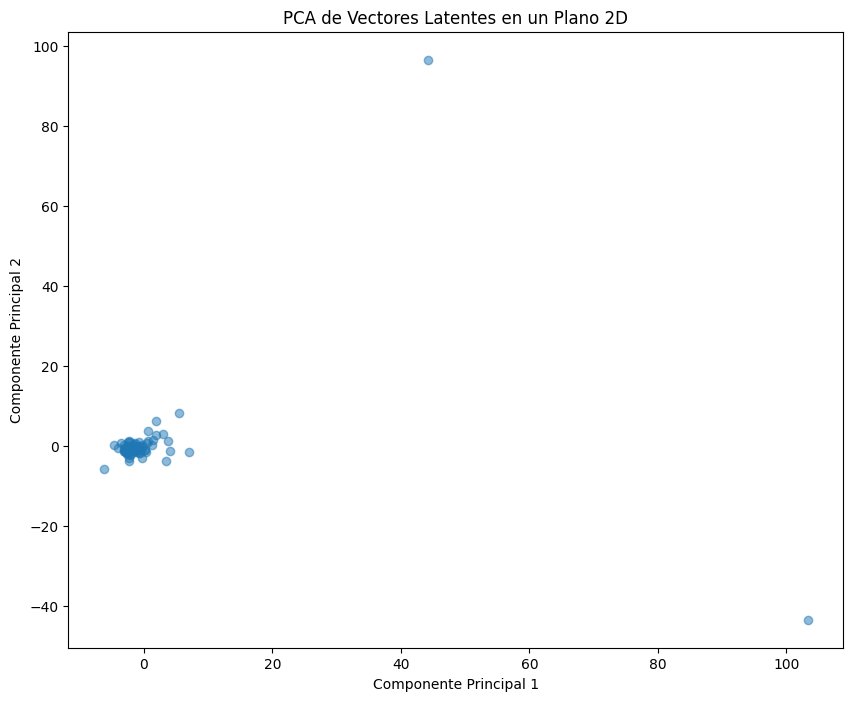

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


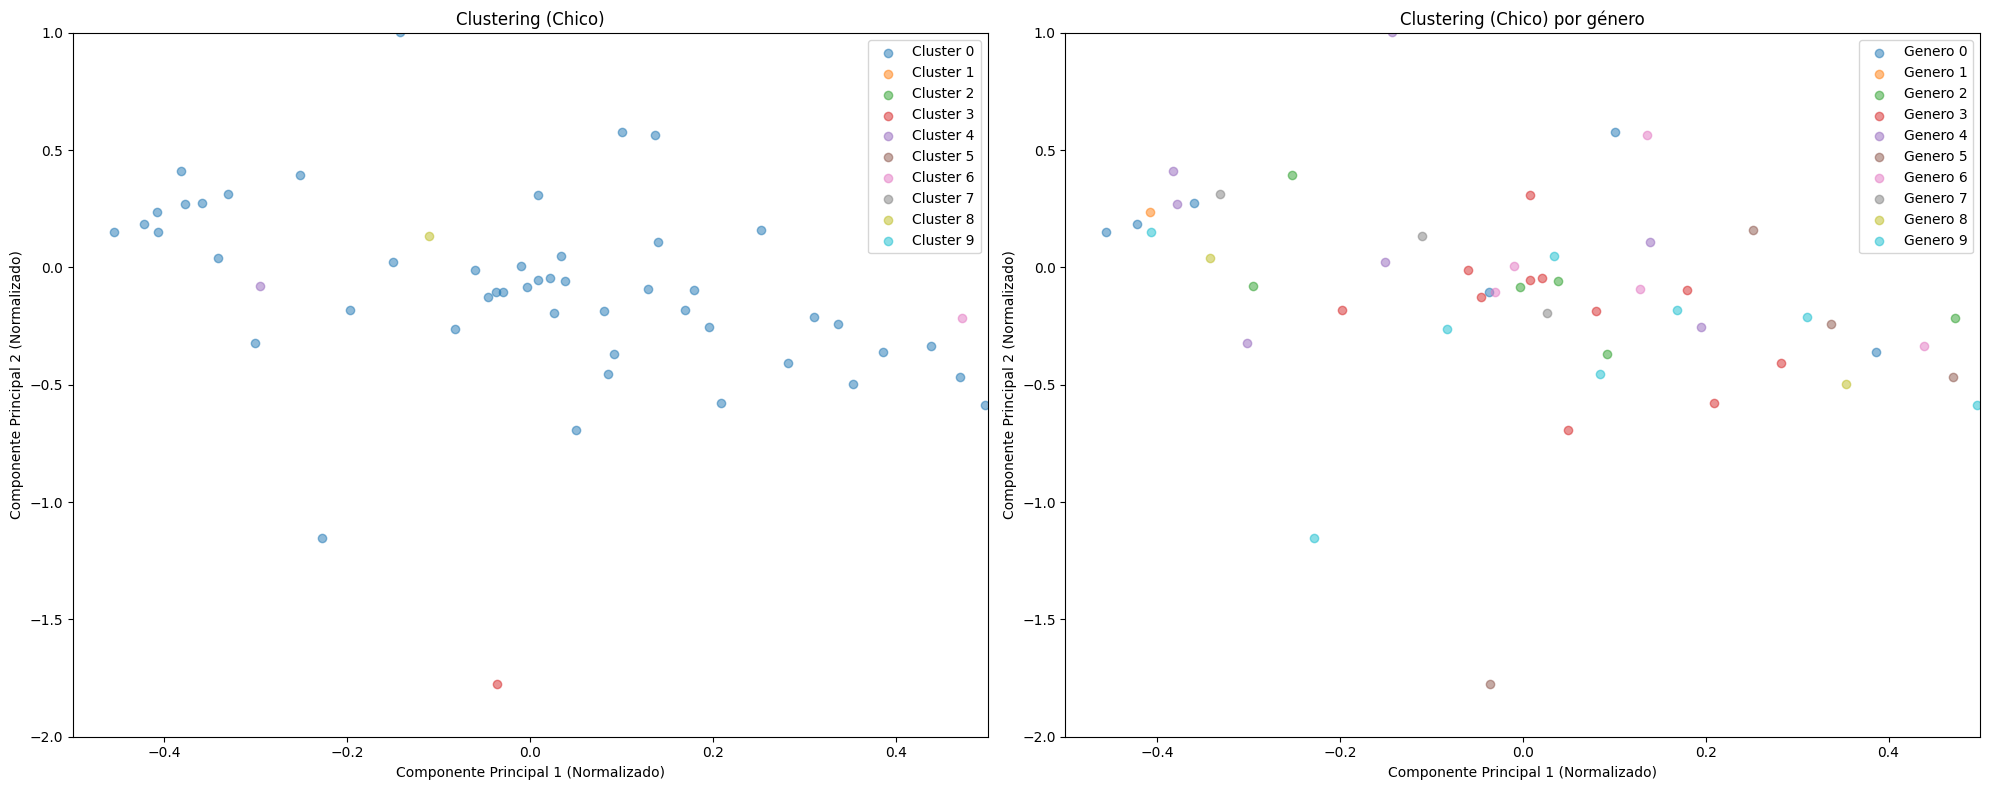

Homogeneidad del clustering: 0.09476080234696158
Completitud del clustering: 0.428626561167065
Matriz de Confusión:
[[11  0  0  0  0  0  0  0  0  0]
 [ 6  0  0  0  0  0  0  0  0  0]
 [ 9  0  0  0  1  0  1  1  0  0]
 [13  0  0  0  0  0  0  0  0  0]
 [14  0  0  0  0  1  0  0  0  0]
 [ 5  0  0  1  0  0  0  0  0  0]
 [ 8  0  1  0  0  0  0  0  0  0]
 [ 6  1  0  0  0  0  0  0  1  0]
 [ 8  0  0  0  0  0  0  0  0  1]
 [11  0  0  0  0  0  0  0  0  0]]

Precisión del Clustering: 0.11
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


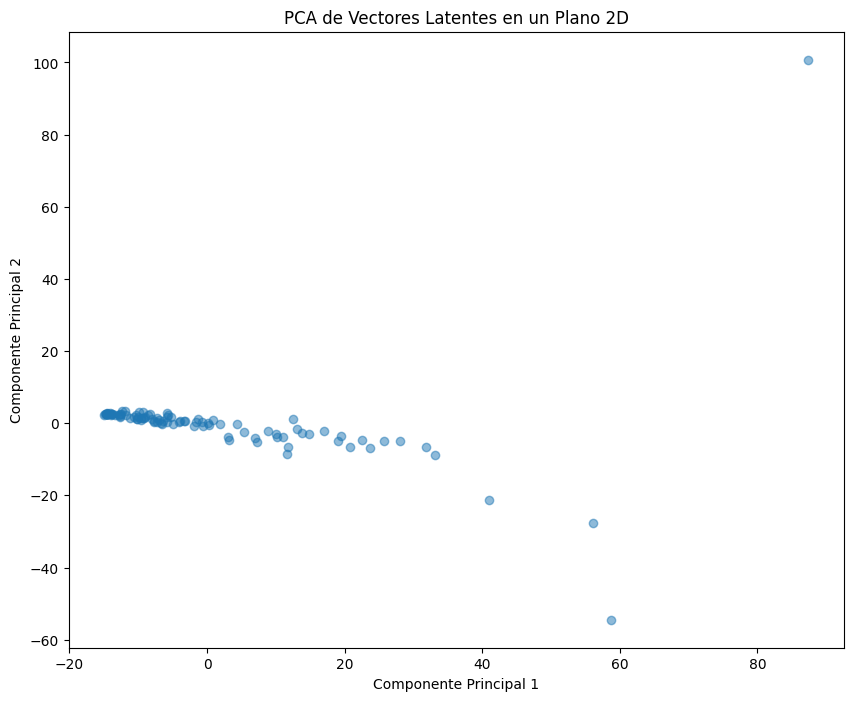

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


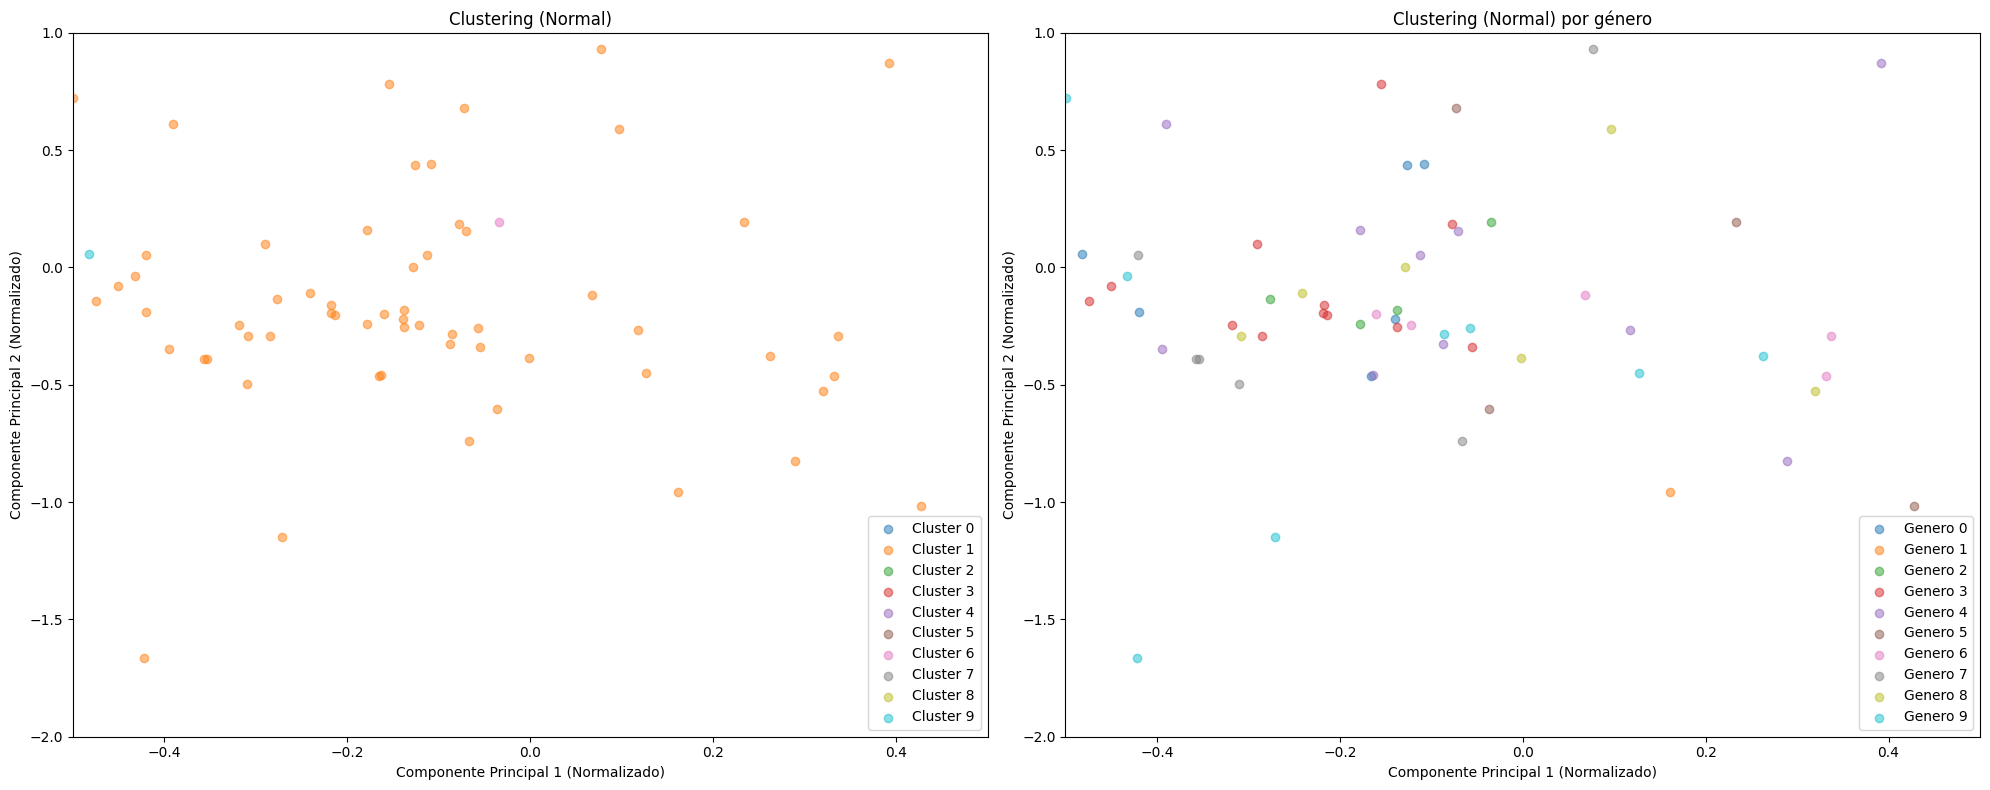

Homogeneidad del clustering: 0.09263884733839202
Completitud del clustering: 0.4190284335051208
Matriz de Confusión:
[[ 0 10  0  0  0  0  0  0  0  1]
 [ 0  6  0  0  0  0  0  0  0  0]
 [ 0  9  1  0  0  0  1  0  1  0]
 [ 0 13  0  0  0  0  0  0  0  0]
 [ 1 14  0  0  0  0  0  0  0  0]
 [ 0  5  0  0  0  1  0  0  0  0]
 [ 0  8  0  0  0  0  0  1  0  0]
 [ 0  7  0  0  1  0  0  0  0  0]
 [ 0  8  0  1  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  0]]

Precisión del Clustering: 0.08
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


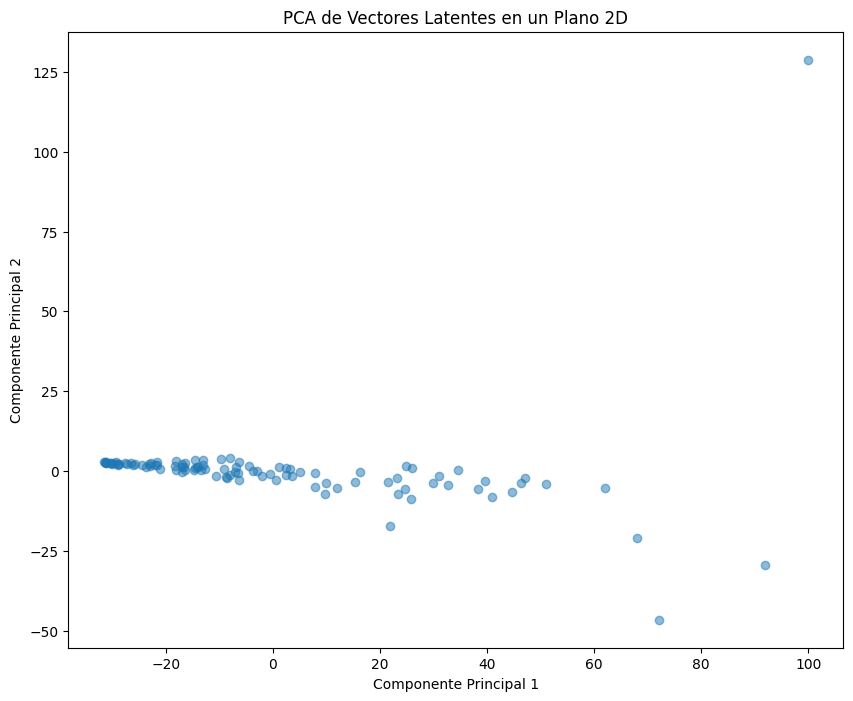

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


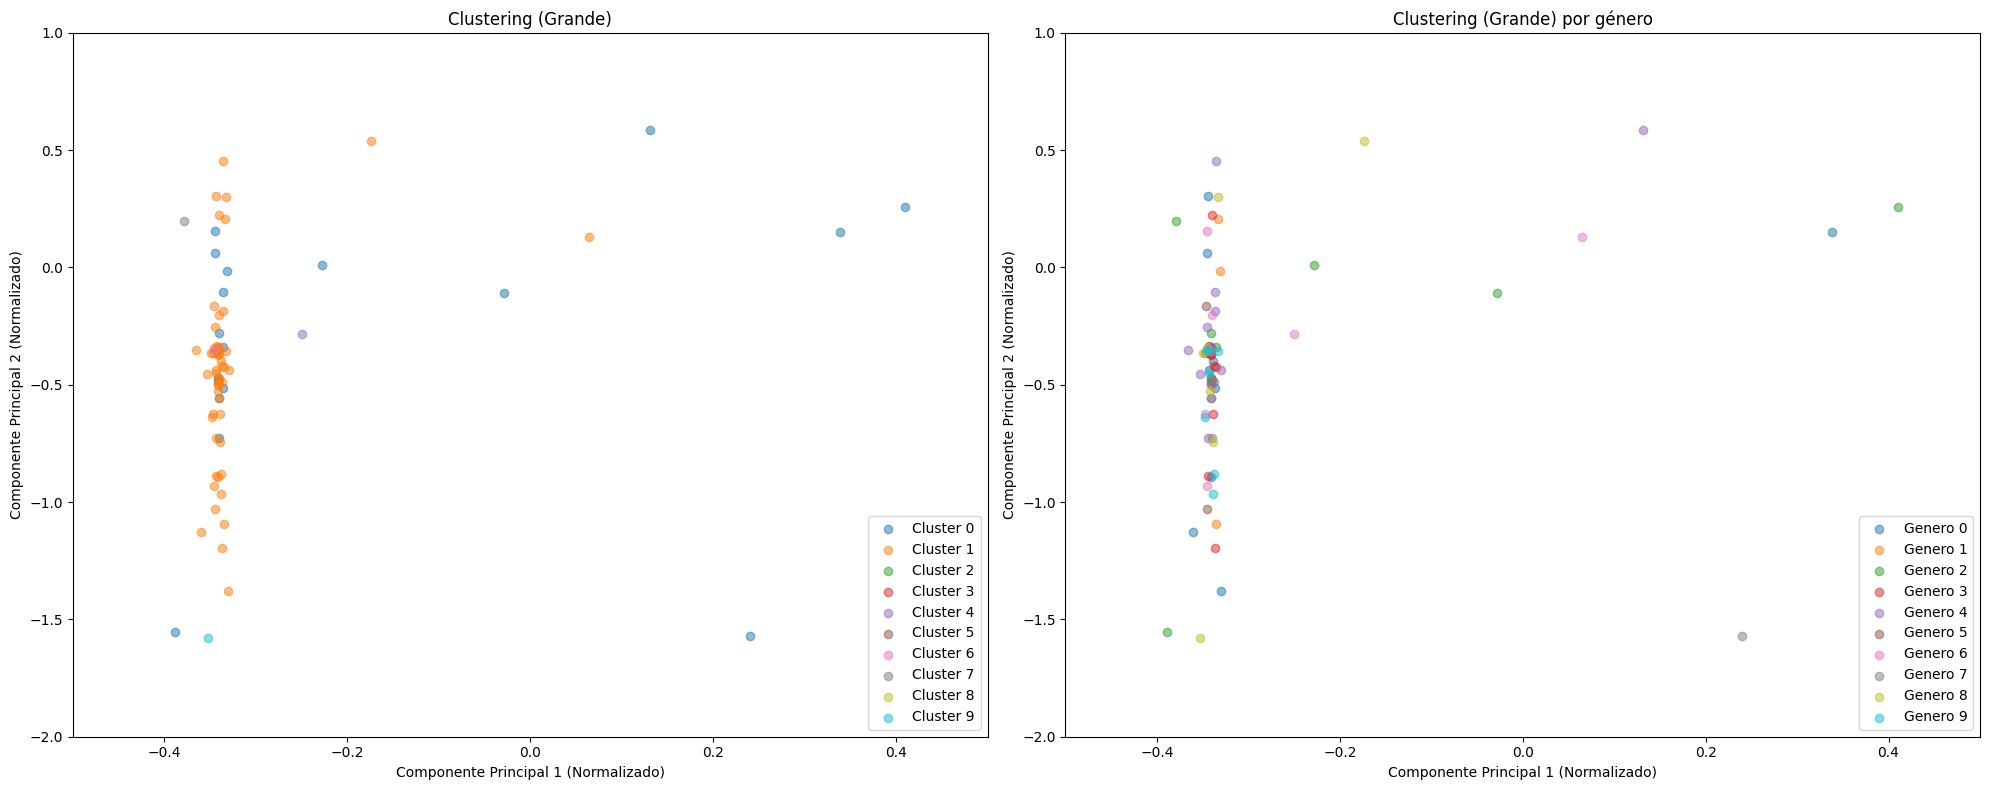

Homogeneidad del clustering: 0.14960864668323953
Completitud del clustering: 0.33789701860611093
Matriz de Confusión:
[[ 4  7  0  0  0  0  0  0  0  0]
 [ 2  3  1  0  0  0  0  0  0  0]
 [ 7  2  0  0  0  0  1  1  1  0]
 [ 0 13  0  0  0  0  0  0  0  0]
 [ 4 11  0  0  0  0  0  0  0  0]
 [ 1  4  0  1  0  0  0  0  0  0]
 [ 2  6  0  0  1  0  0  0  0  0]
 [ 5  2  0  0  0  1  0  0  0  0]
 [ 1  7  0  0  0  0  0  0  0  1]
 [ 1 10  0  0  0  0  0  0  0  0]]

Precisión del Clustering: 0.07


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score, completeness_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# Función para realizar el clustering y visualización
def perform_clustering_and_visualization(latent_matrix, labels, title):
    # Inicializa el objeto PCA con 2 componentes
    pca = PCA(n_components=2)
    # Aplica PCA a la matriz de vectores latentes
    latent_2d = pca.fit_transform(latent_matrix)

    # Normaliza los vectores latentes
    scaler = StandardScaler()
    latent_2d_normalized = scaler.fit_transform(latent_matrix)
    # Visualiza los resultados en un gráfico de dispersión
    plt.figure(figsize=(10, 8))
    plt.scatter(latent_2d[:, 0], latent_2d[:, 1], alpha=0.5)
    plt.title('PCA de Vectores Latentes en un Plano 2D')
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.show()

    # Número de clusters (géneros musicales)
    n_clusters = 10

    # Aplica K-Means al conjunto de vectores latentes normalizados
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(latent_2d_normalized)

    plot_side_by_side_clusters_vs_genres(latent_2d_normalized, cluster_labels, labels, n_clusters, title, f'{title} por género')

    # Calcula la homogeneidad y la completitud
    homogeneity = homogeneity_score(labels, cluster_labels)
    completeness = completeness_score(labels, cluster_labels)

    # Imprime los resultados
    print("Homogeneidad del clustering:", homogeneity)
    print("Completitud del clustering:", completeness)

    # Calcula la matriz de confusión
    conf_matrix = confusion_matrix(labels, cluster_labels)

    # Calcula la precisión del clustering
    accuracy = accuracy_score(labels, cluster_labels)

    # Imprime la matriz de confusión y la precisión
    print("Matriz de Confusión:")
    print(conf_matrix)
    print("\nPrecisión del Clustering:", accuracy)


# Supongamos que 'labels_chico' contiene las etiquetas reales del conjunto chico
# y 'latent_matrix_chico' es la matriz de vectores latentes para el conjunto chico
# Hacer lo mismo para 'labels_normal' y 'latent_matrix_normal', 'labels_grande' y 'latent_matrix_grande'

# Perform clustering y visualización para el conjunto chico
perform_clustering_and_visualization(latent_matrix_chico, labels_chico, 'Clustering (Chico)')
print("--"*100)
# Perform clustering y visualización para el conjunto normal
perform_clustering_and_visualization(latent_matrix_normal, labels_normal, 'Clustering (Normal)')
print("--"*100)
# Perform clustering y visualización para el conjunto grande
perform_clustering_and_visualization(latent_matrix_grande, labels_grande, 'Clustering (Grande)')

In [ ]:
latent_vectors = []
labels = []

# Itera sobre cada audio en tus datos
for wav, label in test_dl_chico.dataset:
    latent_vectors.append(wav.squeeze())
    # Flatten the tensor or convert it to a Python list
    labels.append(label)

# Convertir la lista de vectores latentes a una matriz
latent_matrix = np.vstack(latent_vectors)

# Imprime el tamaño de la matriz resultante
print("Tamaño de la matriz de vectores latentes:", latent_matrix.shape)

Tamaño de la matriz de vectores latentes: (100, 12264)


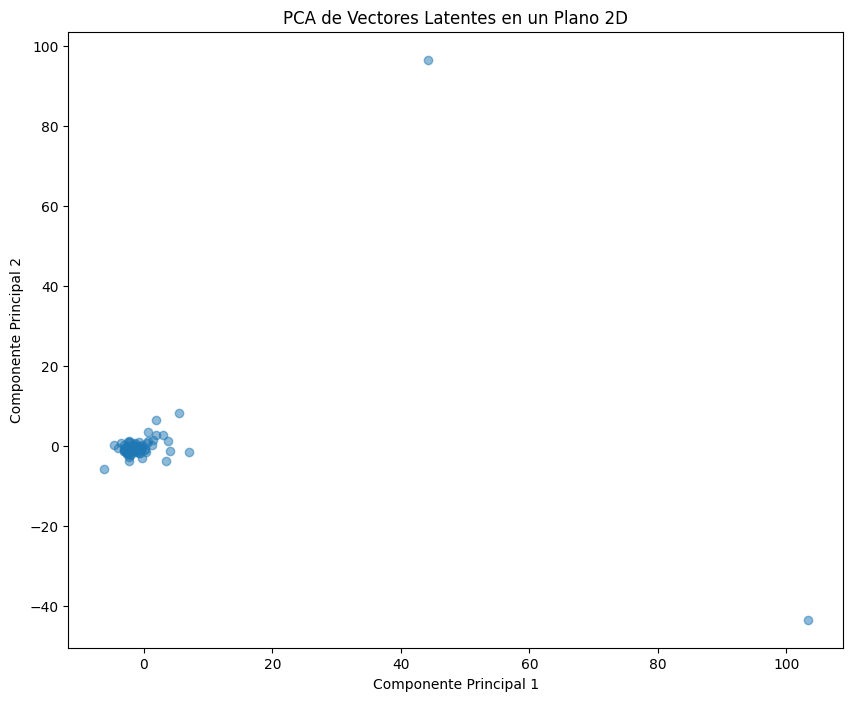

In [ ]:
from sklearn.decomposition import PCA
# Supongamos que latent_matrix es tu matriz de vectores latentes (shape: (n_audios, n_atributos))

# Inicializa el objeto PCA con 2 componentes
pca = PCA(n_components=2)

# Aplica PCA a la matriz de vectores latentes
latent_2d = pca.fit_transform(latent_matrix)

# Visualiza los resultados en un gráfico de dispersión
plt.figure(figsize=(10, 8))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], alpha=0.5)
plt.title('PCA de Vectores Latentes en un Plano 2D')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


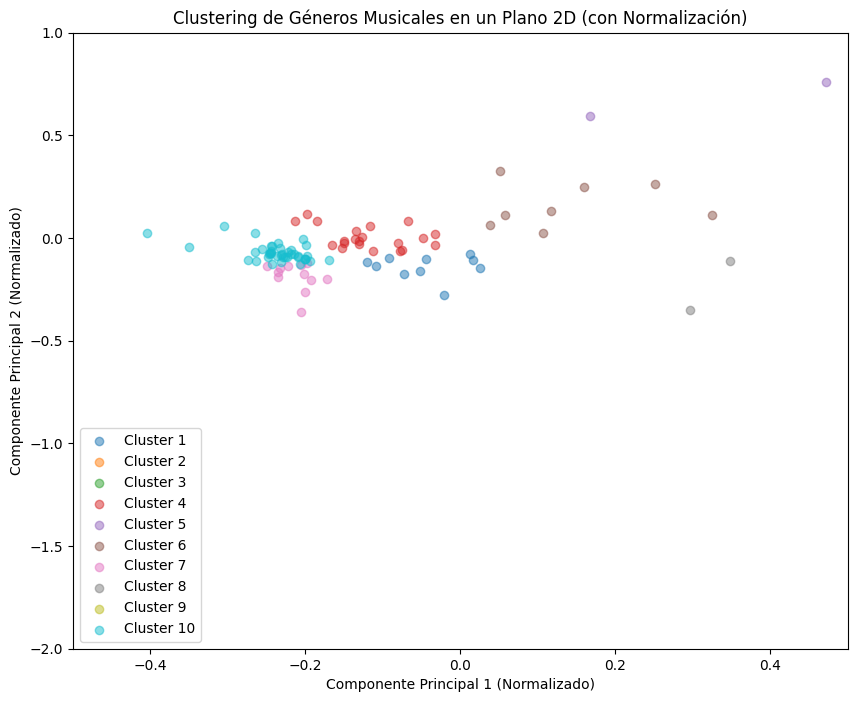

In [ ]:
# Supongamos que latent_2d es tu matriz de vectores latentes después de aplicar PCA (shape: (n_audios, 2))
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
# Normaliza los vectores latentes
scaler = StandardScaler()
latent_2d_normalized = scaler.fit_transform(latent_2d)

# Número de clusters (géneros musicales)
n_clusters = 10

# Aplica K-Means al conjunto de vectores latentes normalizados
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(latent_2d_normalized)

# Visualiza los resultados del clustering en un gráfico de dispersión
plt.figure(figsize=(10, 8))
for cluster in range(n_clusters):
    cluster_points = latent_2d_normalized[cluster_labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster + 1}', alpha=0.5)

# Ajusta los límites de los ejes x e y para ampliar o comprimir la vista
plt.xlim(-0.5, 0.5)
plt.ylim(-2, 1)

plt.title('Clustering de Géneros Musicales en un Plano 2D (con Normalización)')
plt.xlabel('Componente Principal 1 (Normalizado)')
plt.ylabel('Componente Principal 2 (Normalizado)')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import homogeneity_score, completeness_score

# Supongamos que 'labels' contiene las etiquetas reales de los datos

# Calcula la homogeneidad y la completitud
homogeneity = homogeneity_score(labels, cluster_labels)
completeness = completeness_score(labels, cluster_labels)

# Imprime los resultados
print("Homogeneidad del clustering:", homogeneity)
print("Completitud del clustering:", completeness)

Homogeneidad del clustering: 0.19036193052046288
Completitud del clustering: 0.25315407789398003


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


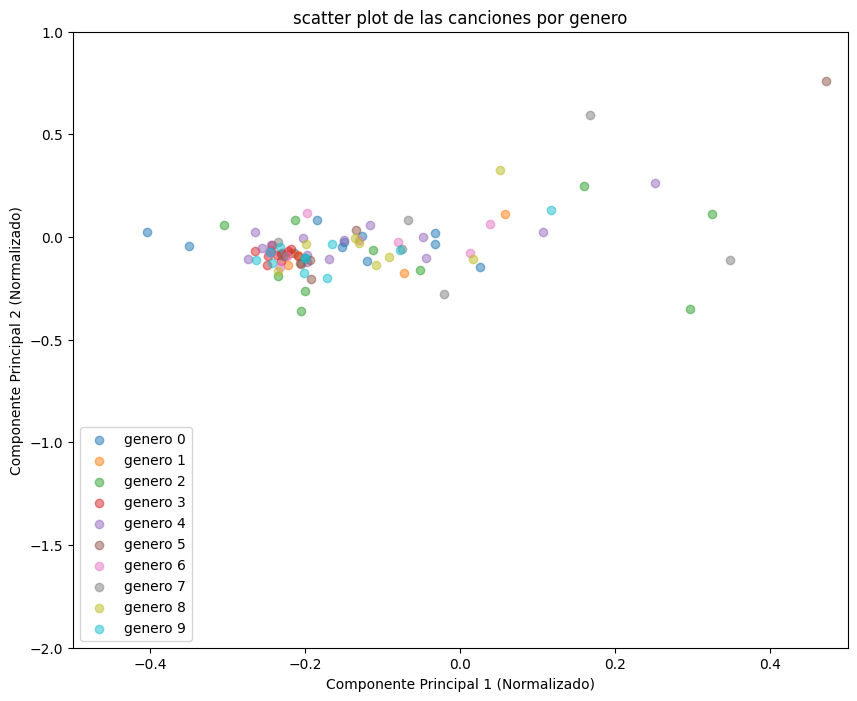

In [ ]:
# Normaliza los vectores latentes
scaler = StandardScaler()
latent_2d_normalized = scaler.fit_transform(latent_2d)

# Número de clusters (géneros musicales)
n_clusters = 10

# Aplica K-Means al conjunto de vectores latentes normalizados
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(latent_2d_normalized)

# Visualiza los resultados del clustering en un gráfico de dispersión
plt.figure(figsize=(10, 8))
for cluster in range(n_clusters):
    cluster_points = latent_2d_normalized[np.array(labels) == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'genero {cluster}', alpha=0.5)

# Ajusta los límites de los ejes x e y para ampliar o comprimir la vista
plt.xlim(-0.5, 0.5)
plt.ylim(-2, 1)

plt.title('scatter plot de las canciones por genero')
plt.xlabel('Componente Principal 1 (Normalizado)')
plt.ylabel('Componente Principal 2 (Normalizado)')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
# Calcula la matriz de confusión
conf_matrix = confusion_matrix(labels, cluster_labels)

# Calcula la precisión del clustering
accuracy = accuracy_score(labels, cluster_labels)

# Imprime la matriz de confusión y la precisión
print("Matriz de Confusión:")
print(conf_matrix)
print("\nPrecisión del Clustering:", accuracy)

Matriz de Confusión:
[[ 2  0  0  6  0  0  0  0  0  3]
 [ 1  0  0  0  0  1  1  0  0  3]
 [ 1  0  0  2  0  2  3  2  0  2]
 [ 0  0  0  0  0  0  1  0  0 12]
 [ 1  0  0  3  0  2  1  0  0  8]
 [ 0  0  0  1  1  0  2  0  0  2]
 [ 1  1  0  3  0  1  1  0  0  2]
 [ 1  0  1  2  1  0  0  1  0  2]
 [ 3  0  0  2  0  1  1  0  1  1]
 [ 0  0  0  2  0  1  2  0  0  6]]

Precisión del Clustering: 0.11


In [ ]:
for n,i in enumerate(latent_2d):
  print(n,i)

0 [-2.5107157 -0.8421009]
1 [-2.4144342 -0.956151 ]
2 [-2.6805634  -0.52959937]
3 [ 7.0077987 -1.5573757]
4 [-2.8493264  -0.81368405]
5 [1.22351    0.24729003]
6 [-2.8766112 -1.477692 ]
7 [3.7381022 1.1981033]
8 [-6.283333  -5.7024574]
9 [0.5876275 3.5310786]
10 [-1.9068139 -0.3720178]
11 [-2.6034076 -1.0145962]
12 [-2.5173185 -0.6325792]
13 [ 4.0078387 -1.1826897]
14 [-0.8372854 -1.8698717]
15 [-2.9423177 -0.5915072]
16 [1.8294723 2.6642354]
17 [-2.3190966 -1.8995609]
18 [-1.9793571 -2.1583767]
19 [-1.068306  -1.0437123]
20 [-2.6687338 -1.2704002]
21 [-2.4126275 -0.9907123]
22 [-2.309072  -1.0728765]
23 [-2.286224  -0.9450067]
24 [-1.7285626  -0.25255388]
25 [-0.3818796  -0.34246495]
26 [-2.123331  0.910175]
27 [-2.8313794 -0.7643433]
28 [0.6631561 1.1965234]
29 [103.38145  -43.508022]
30 [-0.6000263 -1.7479634]
31 [ 0.18456186 -1.1478114 ]
32 [-0.2477561 -2.9852488]
33 [-0.38391423  0.21336608]
34 [-2.8211544 -0.7928446]
35 [-2.2918303  -0.34992164]
36 [-2.2203827 -2.1998727]
37 [-1.

In [ ]:
wav,spec,label = test_dl.dataset[67]
import IPython
IPython.display.Audio(wav,rate=samplerate)

In [ ]:
wav,spec,label = test_dl.dataset[68]
import IPython
IPython.display.Audio(wav,rate=samplerate)

### comparo como se escucha y ve una cancion segun cada espacio latente

shape audio: torch.Size([1, 110250])
shape rec_audio: torch.Size([12264])
shape spec: torch.Size([1, 201, 552])
shape rec_spec: torch.Size([201, 62])
Audio Original


Audio Reconstruido


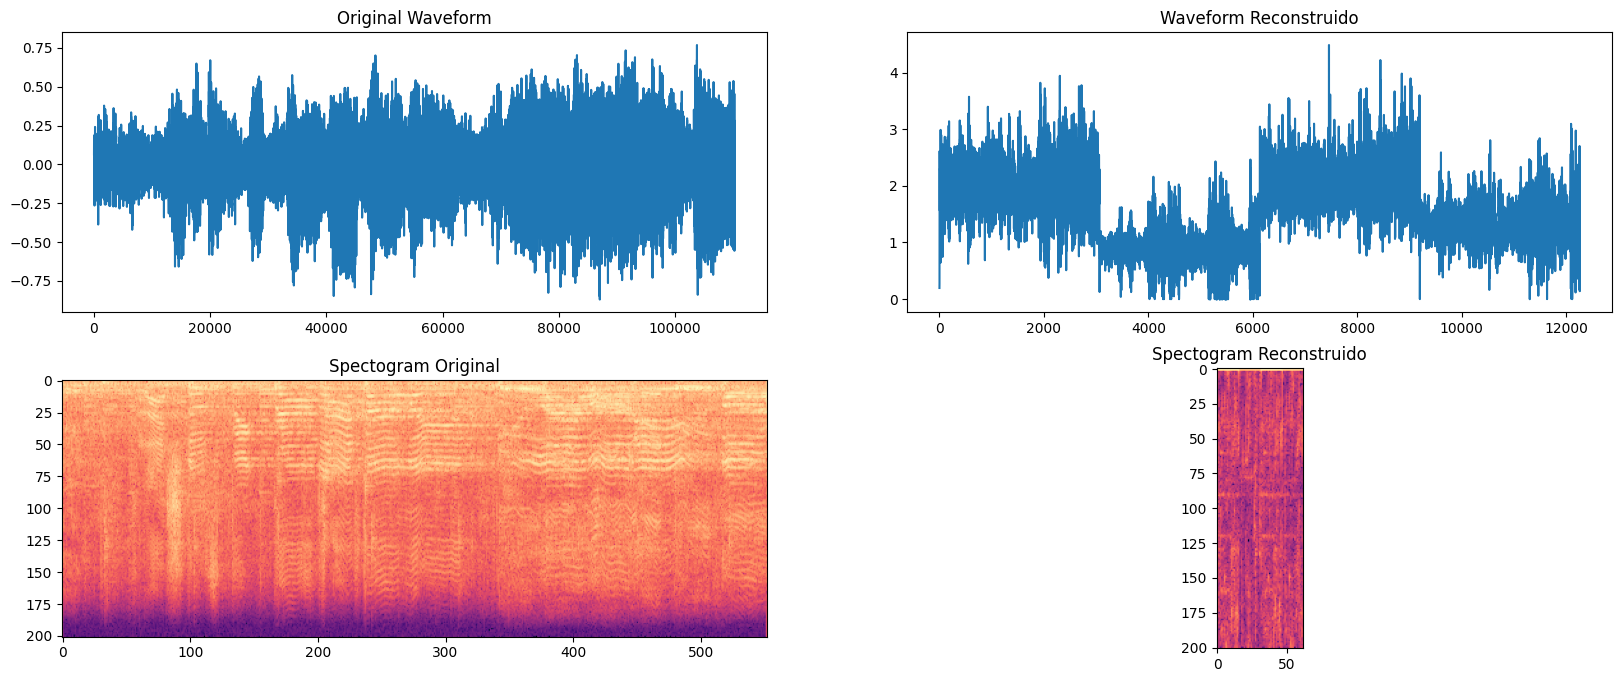

In [ ]:
visualize_dual(encoder_chico, dataset, 5, device)

shape audio: torch.Size([1, 110250])
shape rec_audio: torch.Size([24528])
shape spec: torch.Size([1, 201, 552])
shape rec_spec: torch.Size([201, 123])
Audio Original


Audio Reconstruido


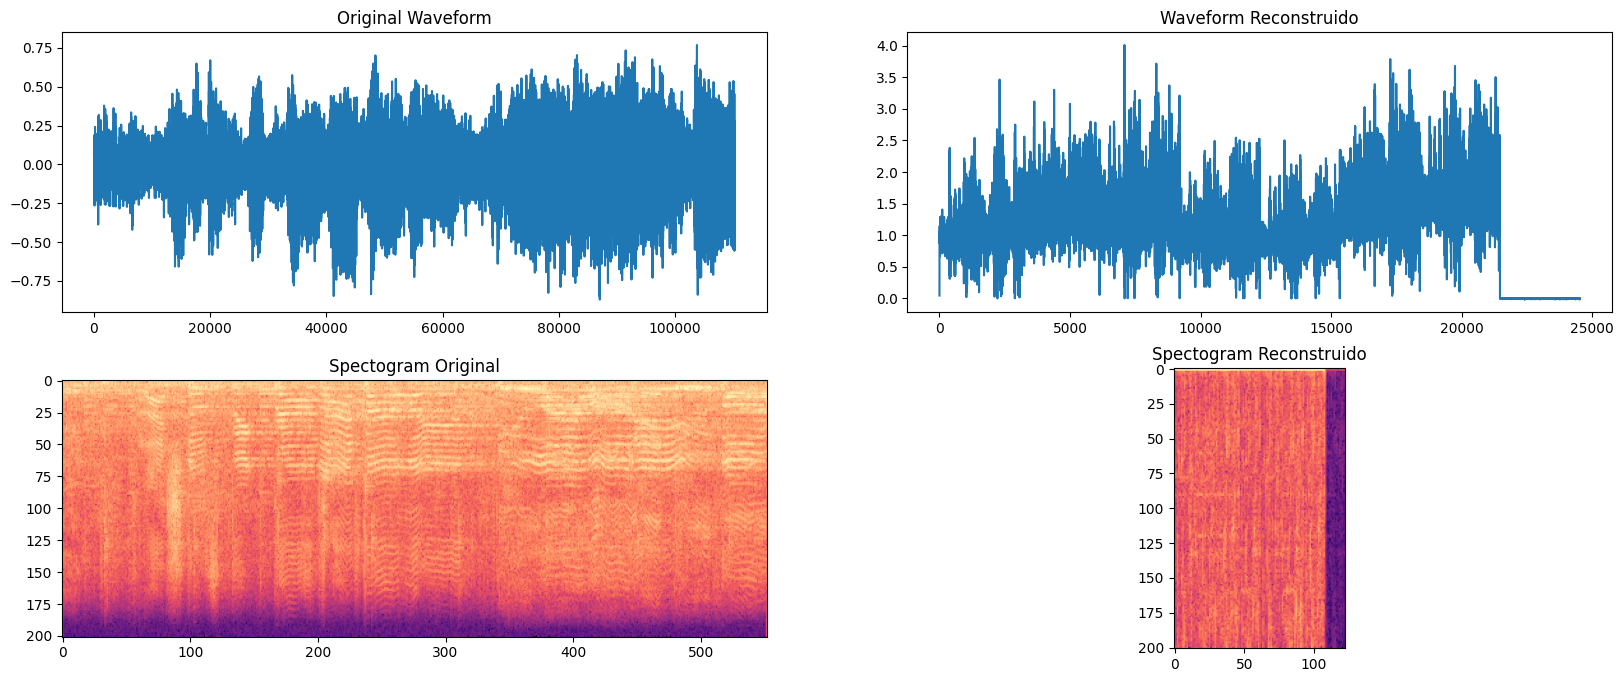

In [ ]:
visualize_dual(encoder_normal, dataset, 5, device)

shape audio: torch.Size([1, 110250])
shape rec_audio: torch.Size([49056])
shape spec: torch.Size([1, 201, 552])
shape rec_spec: torch.Size([201, 246])
Audio Original


Audio Reconstruido


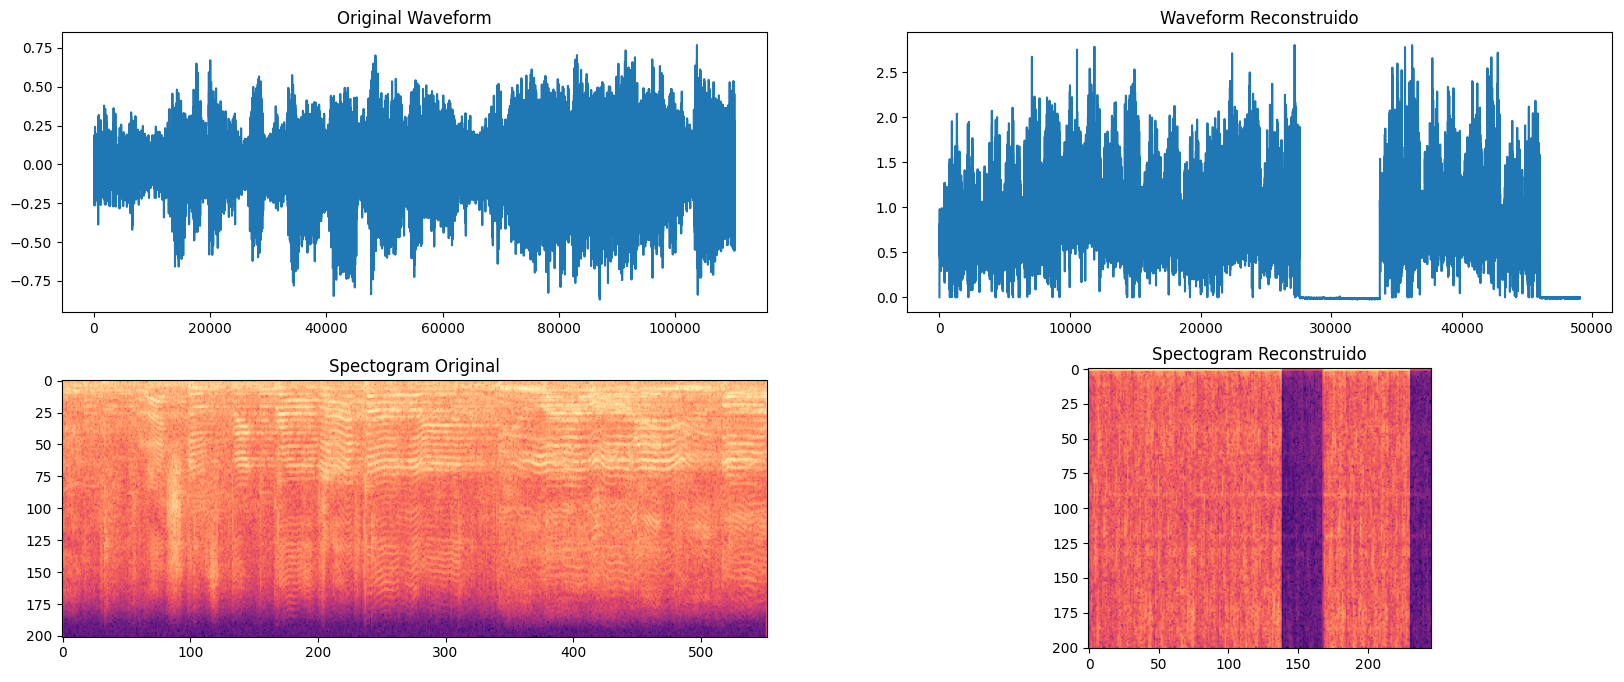

In [ ]:
visualize_dual(encoder_grande, dataset, 5, device)

## Ejerecio 3

### Corregimos el sample rate de las canciones nuevas

In [ ]:
def sample_rate(import_dir, export_dir):
    # cargamos la canción nueva ya recortada (duracion 5 segundos)
    original_audio = AudioSegment.from_file(import_dir)

    # establecemos la nueva tasa de muestreo (22050 Hz)
    new_sample_rate = 22050
    original_audio = original_audio.set_frame_rate(new_sample_rate)

    # exportamos la canción con la nueva tasa de muestreo a una ruta especifica
    original_audio.export(export_dir, format="wav")

# llamamos a la función modificando, para cada audio, la ruta de acceso y la ruta donde se guarda el audio modificado
# sample_rate("./tp4_td6/musica_nueva_5sec/pop.wav", "./tp4_td6/pop_con_nueva_tasa.wav")

### Reducimos los canales

In [ ]:
def channel(import_dir, export_dir):
    # seleccionamos la ruta del archivo de audio ya recortado, con duracion de 5 segundos y con el samplerate adecuado
    ruta_audio = import_dir

    # cargamos el audio usando torchaudio
    waveform, sample_rate = torchaudio.load(ruta_audio, normalize=True)

    # si el audio tiene 2 canales, reducimos la cantidad de canales a 1
    if waveform.size(0) == 2:
        waveform = waveform.mean(dim=0, keepdim=True)

    # guardamos el audio modificado en una ruta de acceso especifica
    torchaudio.save(export_dir, waveform, sample_rate)

# llamamos a la función modificando, para cada audio, la ruta de acceso y la ruta donde se guarda el audio modificado
# channel("./tp4_td6/musica_nueva_5sec/pop/pop.wav"",./tp4_td6/musica_nueva_5sec/pop/pop_1canal.wav")

### importe de cancion y reproduccion

In [ ]:
import os
data_dir='/content/drive/MyDrive/musica_nueva_5sec/'
list_files=os.listdir(data_dir)
classes=[]
for file in list_files:
  name='{}/{}'.format(data_dir,file)
  if os.path.isdir(name):
    classes.append(file)
classes

FileNotFoundError: ignored

In [ ]:
nuevo_dataset = MusicDataset(data_dir)

In [ ]:
audio, spectogram, class_idx = nuevo_dataset[2]
print("shape of waveform {}, sample rate with {}, label is {} ".format(audio.size(),samplerate,class_idx))

shape of waveform torch.Size([1, 110250]), sample rate with 22050, label is 1 


In [ ]:
S = torch.load('best_model_1.ckpt')
model.load_state_dict(S)
print('loaded!')
waveform = audio.to(device)
model = model.to(device)

model.eval()

new_wav = model(waveform)

RuntimeError: ignored

In [ ]:
visualize_dual(model, nuevo_dataset, 2, device)

## Ejerecio 4

VAE

GAN